# Functional Encryption - Classification and information leakage

Our start point is the work on encrypted classification using Function Encryption of the paper [Reading in the Dark: Classifying Encrypted Digits with Functional Encryption](https://eprint.iacr.org/2018/206), and the associated [GitHub repository](https://github.com/edufoursans/reading-in-the-dark).

More specifically, the paper provides a new Functional Encryption scheme for quadratic multi-variate polynomials, which can under some hypothesis be seen as a single hidden layer neural network with a quadratic activation.
In the paper, the output corresponds to element per class, and it is made in clear. We analyse how this output can disclose information about the initial input or about charasteristics of this input.

To this aim, we have just built a dataset which is very similar to MNIST, used in the original paper but which is composed of 26 letter characters of 5 differents fonts. Our goal is two-fold:
 - Evaluate how the output in clear can be leverage with a public NN to make better prediction than a simple `argmax` function in the character recognition task.
 - Analyse to what extent the output in clear of the model trained for character recognition can reveal information about the font used, using an "adversarial" network.
 
### Purpose

Here we go a step back to Part 10, and we'll try to get back to CNN after having spent some time of Feed Forward nets. We'll do the exact same setting than in Part 10, except the collateral model (= the one on which resistance is done = the one which recovers) is now a CNN

As a remainder, what we want to do is to optimize the following problem:
$ \min_Q [ \min_C l_C(Q, C) - \alpha \min_F l_F(Q, F) ] $


Hence, the game is in 3 epoch time (and `F` is a CNN):
 - The normal phase where both tasks learn and strenghten before the joint optimisation:
  - `Optimize: Q + C`
  - `Optimize: Freezed(Q) + F`
 - The phase with the joint optimisation, where C and F are updated depending on the Q variations and Q is optimised to reduce the loss `C - alpha * F`:
  - `Optimize: Freezed(Q) + C`
  - `Optimize: Freezed(Q) + F`
  - `Optimize : Q + [Freezed(C) - alpha * Freezed(F)]`
 - The recovery part, where both tasks recover from the perturbation, `Q` won't change now:
  - `Optimize: Freezed(Q) + C`
  - `Optimize: Freezed(Q) + F`


# 1. Joint optimisation


We will use the code directly from the repo, to make the notebook more readable. Functions are similar to those presented earlier.

In [1]:
# Allow to load packages from parent
import sys, os
sys.path.insert(1, os.path.realpath(os.path.pardir))

In [2]:
import random

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as utils

import learn
from learn import load_data, show_results

In [3]:
class Parser:
    """Parameters for the training"""
    def __init__(self):
        self.epochs = 10
        self.sabotage_epochs = 10
        self.recovering_epochs = 10
        self.lr = 0.002
        self.momentum = 0.5
        self.test_batch_size = 1000
        self.batch_size = 64
        self.log_interval = 100

Let's define the model with the describes architecture. Basically you have 3 blocs: 1 quadratic and 2 CNN.

In [10]:
N_CHARS = 26
N_FONTS = 5
class QuadConvNet(nn.Module):
    def __init__(self):
        super(QuadConvNet, self).__init__()
        self.proj1 = nn.Linear(784, 50)
        self.diag1 = nn.Linear(50, 8)
        
        # --- FFN for characters
        self.lin1 = nn.Linear(8, 16)
        self.lin2 = nn.Linear(16, N_CHARS)
        
        # --- Junction
        self.jct = nn.Linear(8, 784)
        
        # --- CNN for families
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, N_FONTS)
        
    def quad(self, x):
        """Same as forward up to the junction part
        Used for the collateral training"""
        # --- Quadratic 
        x = x.view(-1, 784)
        x = self.proj1(x)
        x = x * x
        x = self.diag1(x)
        return x
    
    def conv_char(self, x):
        # --- FFN
        x = F.relu(self.lin1(x))
        x = self.lin2(x)
        return x
        
    def conv_font(self, x):
        # --- Junction
        x = self.jct(x)
        x = x.view(-1, 1, 28, 28)
        
        # --- CNN
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def forward_char(self, x):
        x = self.quad(x)
        x = self.conv_char(x)
        return F.log_softmax(x, dim=1)
    
    def forward_font(self, x):
        x = self.quad(x)
        x = self.conv_font(x)
        return F.log_softmax(x, dim=1)
    
    def get_params(self, net):
        """Select the params for a given part of the net"""
        if net == 'quad':
            layers = [self.proj1, self.diag1]
        elif net == 'char':
            layers = [self.lin1, self.lin2]
        elif net == 'font':
            layers = [self.jct, self.fc1, self.fc2, self.conv1, self.conv2]
        else:
            raise AttributeError(f'{net} type not recognized')
        params = [p for layer in layers for p in layer.parameters()]
        return params
    
    def freeze(self, net):
        """Freeze a part of the net"""
        net_params = self.get_params(net)
        for param in net_params:
            param.requires_grad = False
            
    def unfreeze(self):
        """Unfreeze the net"""
        for param in self.parameters():
            param.requires_grad = True
        
        

Next, we define the train and test functions. They assume the train_load return two labels: the char and the font of some input.

In the training phase we execute the 3 steps as described aboved.

In the test function, we just test the performance for the main and collateral tasks.

In [11]:
def train(args, model, train_loader, optimizer, epoch, alpha, initial_phase, perturbate):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # Split the two targets
        target_char = target[:, 0]
        target_font = target[:, 1]
        
        
        # Optimize C and F parts of the model with 2 strategies
        if initial_phase:  # Normal optimisation of C
            # Phase 1: Optimise Q + C
            optimizer.zero_grad()
            output = model.forward_char(data)
            loss_char = F.nll_loss(output, target_char)
            loss_char.backward()
            optimizer.step()
        else: # Freezed(Q) optimisation
            # Phase 1: Optimise Freezed(Q) + F
            model.freeze('quad')
            optimizer.zero_grad()
            output_char = model.forward_char(data)
            loss_char = F.nll_loss(output_char, target_char)
            loss_char.backward()
            optimizer.step()
            model.unfreeze()
        # Phase 2: Optimise Freezed(Q) + F
        model.freeze('quad')
        output_font = model.forward_font(data)
        loss_font = F.nll_loss(output_font, target_font)
        loss_font.backward()
        optimizer.step()
        model.unfreeze()
        
        if perturbate:
            # Optimize Q
            model.freeze('font')
            model.freeze('char')
            optimizer.zero_grad()
            output_char = model.forward_char(data)
            loss_char = F.nll_loss(output_char, target_char)

            output_font = model.forward_font(data)
            loss_font = F.nll_loss(output_font, target_font)

            loss = loss_char - alpha * loss_font
            loss.backward()
            optimizer.step()
            model.unfreeze()
        
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss Char: {:.6f} Loss Font: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), loss_char.item(), loss_font.item()))

In [12]:
def test(args, model, test_loader):
    model.eval()
    correct_char = 0
    correct_font = 0
    with torch.no_grad():
        for data, target in test_loader:
            # Split the two targets
            target_char = target[:, 0]
            target_font = target[:, 1]

            # Char evaluation
            output = model.forward_char(data)
            pred = output.argmax(1, keepdim=True)
            correct_char += pred.eq(target_char.view_as(pred)).sum().item()
            
            # Font evaluation
            output = model.forward_font(data)
            pred = output.argmax(1, keepdim=True)
            correct_font += pred.eq(target_font.view_as(pred)).sum().item()

    acc_char = 100. * correct_char / len(test_loader.dataset)
    acc_font = 100. * correct_font / len(test_loader.dataset)
    print('\nTest set: Accuracy Char : {}/{} ({:.2f}%)\n          Accuracy Font : {}/{} ({:.2f}%)'.format(
        correct_char, len(test_loader.dataset), acc_char, correct_font, len(test_loader.dataset), acc_font))

    return acc_char, acc_font

Now we can handle the main function. The only thing that really changes is that we now want to have both labels associated to a input item.

In [13]:
def build_tensor_dataset(data, target):
    """Utility function to cast our data into a normalized torch TensorDataset"""
    normed_data = [(d - d.mean()) / d.std() for d in data]
    normed_data = torch.stack([torch.Tensor(d).reshape(1, 28, 28) for d in normed_data])
    target = torch.LongTensor([[i[0][0], i[1][0]] for i in target])
    tensor_dataset = utils.TensorDataset(normed_data, target)
    return tensor_dataset

Last the main function !

In [14]:
def main(alpha=0):
    """
    Perform a learning phase
    """
    torch.manual_seed(1)
    args = Parser()

    data = load_data()
    train_data, train_target_char, train_target_family, test_data, test_target_char, test_target_family = data
    # Merge the target datasets
    train_target = list(zip(train_target_char, train_target_family))
    test_target = list(zip(test_target_char, test_target_family))

    # We use here the slightly modified version of this function
    train_dataset = build_tensor_dataset(train_data, train_target)
    test_dataset = build_tensor_dataset(test_data, test_target)

    train_loader = utils.DataLoader(
        train_dataset,
        batch_size=args.batch_size, shuffle=True
    )

    test_loader = utils.DataLoader(
        test_dataset,
        batch_size=args.test_batch_size, shuffle=True
    )
   
    model = QuadConvNet()

    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
    
    test_perfs_char = []
    test_perfs_font = []
    
    for epoch in range(1, args.epochs + args.sabotage_epochs + args.recovering_epochs + 1):
        initial_phase = epoch <= args.epochs
        if initial_phase:
            print("(initial phase)")
        perturbate = epoch > args.epochs and epoch <= args.epochs + args.sabotage_epochs
        if perturbate:
            print("(perturbate)")
        train(args, model, train_loader, optimizer, epoch, alpha, initial_phase, perturbate)
        test_perf_char, test_perf_font = test(args, model, test_loader)
        test_perfs_char.append(test_perf_char)
        test_perfs_font.append(test_perf_font)

    return test_perfs_char, test_perfs_font, model

In [15]:
results = {}
test_perfs_char_clean, test_perfs_font_clean, model_clean = main(alpha=0)
results["Main task in the normal setting"] = test_perfs_char_clean
results["Collateral task in the normal setting"] = test_perfs_font_clean

Training set 60000 items
Testing set  10000 items
(initial phase)
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 3.282281 Loss Font: 1.617083
Train Epoch: 1 [6400/60000 (11%)]	Loss Char: 3.238310 Loss Font: 1.611116
Train Epoch: 1 [12800/60000 (21%)]	Loss Char: 3.190925 Loss Font: 1.615991
Train Epoch: 1 [19200/60000 (32%)]	Loss Char: 2.887891 Loss Font: 1.596917
Train Epoch: 1 [25600/60000 (43%)]	Loss Char: 2.791309 Loss Font: 1.609878
Train Epoch: 1 [32000/60000 (53%)]	Loss Char: 2.480418 Loss Font: 1.579072
Train Epoch: 1 [38400/60000 (64%)]	Loss Char: 2.219752 Loss Font: 1.598853
Train Epoch: 1 [44800/60000 (75%)]	Loss Char: 2.006645 Loss Font: 1.626915
Train Epoch: 1 [51200/60000 (85%)]	Loss Char: 1.787463 Loss Font: 1.557111
Train Epoch: 1 [57600/60000 (96%)]	Loss Char: 1.595119 Loss Font: 1.481910

Test set: Accuracy Char : 4838/10000 (48.38%)
          Accuracy Font : 3213/10000 (32.13%)
(initial phase)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 1.609124 Loss Font: 1.462690
Train Epoch

Train Epoch: 10 [38400/60000 (64%)]	Loss Char: 0.324269 Loss Font: 1.001607
Train Epoch: 10 [44800/60000 (75%)]	Loss Char: 0.379102 Loss Font: 0.915989
Train Epoch: 10 [51200/60000 (85%)]	Loss Char: 0.109716 Loss Font: 0.682625
Train Epoch: 10 [57600/60000 (96%)]	Loss Char: 0.094382 Loss Font: 0.770402

Test set: Accuracy Char : 9338/10000 (93.38%)
          Accuracy Font : 6550/10000 (65.50%)
(perturbate)
Train Epoch: 11 [0/60000 (0%)]	Loss Char: 0.115899 Loss Font: 0.706715
Train Epoch: 11 [6400/60000 (11%)]	Loss Char: 0.197346 Loss Font: 0.843567
Train Epoch: 11 [12800/60000 (21%)]	Loss Char: 0.107002 Loss Font: 0.621825
Train Epoch: 11 [19200/60000 (32%)]	Loss Char: 0.058439 Loss Font: 0.662887
Train Epoch: 11 [25600/60000 (43%)]	Loss Char: 0.171540 Loss Font: 0.553202
Train Epoch: 11 [32000/60000 (53%)]	Loss Char: 0.074725 Loss Font: 0.563649
Train Epoch: 11 [38400/60000 (64%)]	Loss Char: 0.175081 Loss Font: 0.687228
Train Epoch: 11 [44800/60000 (75%)]	Loss Char: 0.112805 Loss Fon

Train Epoch: 20 [6400/60000 (11%)]	Loss Char: 0.028715 Loss Font: 0.386925
Train Epoch: 20 [12800/60000 (21%)]	Loss Char: 0.026304 Loss Font: 0.593463
Train Epoch: 20 [19200/60000 (32%)]	Loss Char: 0.025161 Loss Font: 0.470244
Train Epoch: 20 [25600/60000 (43%)]	Loss Char: 0.215700 Loss Font: 0.552092
Train Epoch: 20 [32000/60000 (53%)]	Loss Char: 0.157356 Loss Font: 0.463799
Train Epoch: 20 [38400/60000 (64%)]	Loss Char: 0.030429 Loss Font: 0.526507
Train Epoch: 20 [44800/60000 (75%)]	Loss Char: 0.172187 Loss Font: 0.510306
Train Epoch: 20 [51200/60000 (85%)]	Loss Char: 0.030953 Loss Font: 0.647963
Train Epoch: 20 [57600/60000 (96%)]	Loss Char: 0.046108 Loss Font: 0.609559

Test set: Accuracy Char : 9459/10000 (94.59%)
          Accuracy Font : 6954/10000 (69.54%)
Train Epoch: 21 [0/60000 (0%)]	Loss Char: 0.129133 Loss Font: 0.729933
Train Epoch: 21 [6400/60000 (11%)]	Loss Char: 0.132766 Loss Font: 0.746403
Train Epoch: 21 [12800/60000 (21%)]	Loss Char: 0.066984 Loss Font: 0.611810
Tr

Train Epoch: 29 [57600/60000 (96%)]	Loss Char: 0.141698 Loss Font: 0.723223

Test set: Accuracy Char : 9491/10000 (94.91%)
          Accuracy Font : 7121/10000 (71.21%)
Train Epoch: 30 [0/60000 (0%)]	Loss Char: 0.034644 Loss Font: 0.700898
Train Epoch: 30 [6400/60000 (11%)]	Loss Char: 0.148666 Loss Font: 0.737695
Train Epoch: 30 [12800/60000 (21%)]	Loss Char: 0.062857 Loss Font: 0.831717
Train Epoch: 30 [19200/60000 (32%)]	Loss Char: 0.043445 Loss Font: 0.704786
Train Epoch: 30 [25600/60000 (43%)]	Loss Char: 0.050624 Loss Font: 0.495185
Train Epoch: 30 [32000/60000 (53%)]	Loss Char: 0.060923 Loss Font: 0.603229
Train Epoch: 30 [38400/60000 (64%)]	Loss Char: 0.092024 Loss Font: 0.723760
Train Epoch: 30 [44800/60000 (75%)]	Loss Char: 0.029330 Loss Font: 0.538948
Train Epoch: 30 [51200/60000 (85%)]	Loss Char: 0.090077 Loss Font: 0.809485
Train Epoch: 30 [57600/60000 (96%)]	Loss Char: 0.052400 Loss Font: 0.646205

Test set: Accuracy Char : 9466/10000 (94.66%)
          Accuracy Font : 7021

In [16]:
alphas = [1.5] #0.05, 0.1, 0.2, 0.5, 1, 1.5, 2
for alpha in alphas:
    test_perfs_char_perturbate, test_perfs_font_perturbate, model_perturbate = main(alpha=alpha)
    results[f"Main task with perturbation alpha={alpha}"] = test_perfs_char_perturbate
    results[f"Collateral task with perturbation alpha={alpha}"] = test_perfs_font_perturbate

Training set 60000 items
Testing set  10000 items
(initial phase)
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 3.282281 Loss Font: 1.617083
Train Epoch: 1 [6400/60000 (11%)]	Loss Char: 3.238310 Loss Font: 1.611116
Train Epoch: 1 [12800/60000 (21%)]	Loss Char: 3.190925 Loss Font: 1.615991
Train Epoch: 1 [19200/60000 (32%)]	Loss Char: 2.887891 Loss Font: 1.596917
Train Epoch: 1 [25600/60000 (43%)]	Loss Char: 2.791309 Loss Font: 1.609878
Train Epoch: 1 [32000/60000 (53%)]	Loss Char: 2.480418 Loss Font: 1.579072
Train Epoch: 1 [38400/60000 (64%)]	Loss Char: 2.219752 Loss Font: 1.598853
Train Epoch: 1 [44800/60000 (75%)]	Loss Char: 2.006645 Loss Font: 1.626915
Train Epoch: 1 [51200/60000 (85%)]	Loss Char: 1.787463 Loss Font: 1.557111
Train Epoch: 1 [57600/60000 (96%)]	Loss Char: 1.595119 Loss Font: 1.481910

Test set: Accuracy Char : 4838/10000 (48.38%)
          Accuracy Font : 3213/10000 (32.13%)
(initial phase)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 1.609124 Loss Font: 1.462690
Train Epoch

Train Epoch: 10 [38400/60000 (64%)]	Loss Char: 0.324269 Loss Font: 1.001607
Train Epoch: 10 [44800/60000 (75%)]	Loss Char: 0.379102 Loss Font: 0.915989
Train Epoch: 10 [51200/60000 (85%)]	Loss Char: 0.109716 Loss Font: 0.682625
Train Epoch: 10 [57600/60000 (96%)]	Loss Char: 0.094382 Loss Font: 0.770402

Test set: Accuracy Char : 9338/10000 (93.38%)
          Accuracy Font : 6550/10000 (65.50%)
(perturbate)
Train Epoch: 11 [0/60000 (0%)]	Loss Char: 0.115899 Loss Font: 0.706715
Train Epoch: 11 [6400/60000 (11%)]	Loss Char: 0.304620 Loss Font: 1.335519
Train Epoch: 11 [12800/60000 (21%)]	Loss Char: 0.289326 Loss Font: 1.372559
Train Epoch: 11 [19200/60000 (32%)]	Loss Char: 0.199406 Loss Font: 1.326787
Train Epoch: 11 [25600/60000 (43%)]	Loss Char: 0.458036 Loss Font: 1.226230
Train Epoch: 11 [32000/60000 (53%)]	Loss Char: 0.162026 Loss Font: 1.309525
Train Epoch: 11 [38400/60000 (64%)]	Loss Char: 0.404062 Loss Font: 1.361771
Train Epoch: 11 [44800/60000 (75%)]	Loss Char: 0.183322 Loss Fon

Train Epoch: 20 [6400/60000 (11%)]	Loss Char: 0.125229 Loss Font: 1.505483
Train Epoch: 20 [12800/60000 (21%)]	Loss Char: 0.069475 Loss Font: 1.527327
Train Epoch: 20 [19200/60000 (32%)]	Loss Char: 0.125225 Loss Font: 1.506909
Train Epoch: 20 [25600/60000 (43%)]	Loss Char: 0.275526 Loss Font: 1.547805
Train Epoch: 20 [32000/60000 (53%)]	Loss Char: 0.227723 Loss Font: 1.508588
Train Epoch: 20 [38400/60000 (64%)]	Loss Char: 0.072296 Loss Font: 1.524249
Train Epoch: 20 [44800/60000 (75%)]	Loss Char: 0.263304 Loss Font: 1.504142
Train Epoch: 20 [51200/60000 (85%)]	Loss Char: 0.102916 Loss Font: 1.552755
Train Epoch: 20 [57600/60000 (96%)]	Loss Char: 0.163000 Loss Font: 1.550633

Test set: Accuracy Char : 8826/10000 (88.26%)
          Accuracy Font : 2969/10000 (29.69%)
Train Epoch: 21 [0/60000 (0%)]	Loss Char: 0.562028 Loss Font: 1.549459
Train Epoch: 21 [6400/60000 (11%)]	Loss Char: 0.192168 Loss Font: 1.556612
Train Epoch: 21 [12800/60000 (21%)]	Loss Char: 0.083959 Loss Font: 1.556069
Tr

Train Epoch: 29 [57600/60000 (96%)]	Loss Char: 0.217920 Loss Font: 1.400301

Test set: Accuracy Char : 9108/10000 (91.08%)
          Accuracy Font : 4434/10000 (44.34%)
Train Epoch: 30 [0/60000 (0%)]	Loss Char: 0.274701 Loss Font: 1.350492
Train Epoch: 30 [6400/60000 (11%)]	Loss Char: 0.169037 Loss Font: 1.572695
Train Epoch: 30 [12800/60000 (21%)]	Loss Char: 0.125399 Loss Font: 1.445768
Train Epoch: 30 [19200/60000 (32%)]	Loss Char: 0.281751 Loss Font: 1.405328
Train Epoch: 30 [25600/60000 (43%)]	Loss Char: 0.194043 Loss Font: 1.331361
Train Epoch: 30 [32000/60000 (53%)]	Loss Char: 0.253592 Loss Font: 1.287411
Train Epoch: 30 [38400/60000 (64%)]	Loss Char: 0.161123 Loss Font: 1.473385
Train Epoch: 30 [44800/60000 (75%)]	Loss Char: 0.061373 Loss Font: 1.297094
Train Epoch: 30 [51200/60000 (85%)]	Loss Char: 0.230127 Loss Font: 1.413350
Train Epoch: 30 [57600/60000 (96%)]	Loss Char: 0.099230 Loss Font: 1.326828

Test set: Accuracy Char : 9176/10000 (91.76%)
          Accuracy Font : 4341

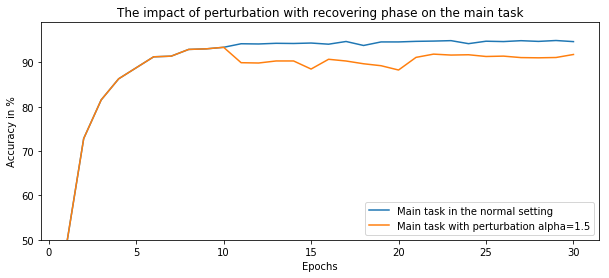

In [23]:
main_results = {k:v for k, v in results.items() if 'Main' in k}
show_results(main_results, "The impact of perturbation with recovering phase on the main task", ymin=50, ymax=99)

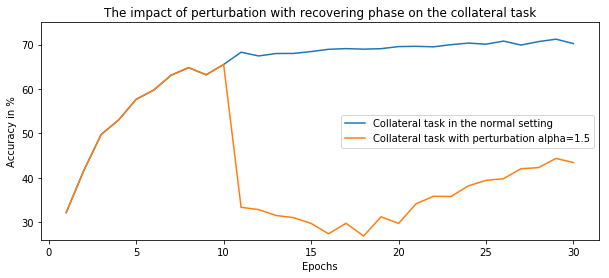

In [20]:
collateral_results = {k:v for k, v in results.items() if 'Collateral' in k}
show_results(collateral_results, "The impact of perturbation with recovering phase on the collateral task", ymin=26, ymax=75)

We clearly distinguish the difference between the 3 phases, when we start perturbing Q against the collateral task and  the recovering part starts as it helps recovering a bit of accuracy in the most perturbed settings.
What we observe is that we achieve a very good trade-off, as the main task has a 3 points drop in accuracy while the collateral task suffers from a 27 points drop!

We report the results for a better visualisation of the trade-off that we have now, even if we have only one value for alpha.

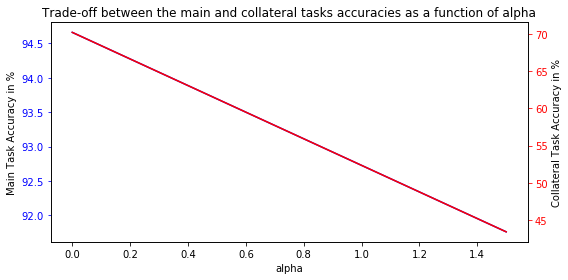

In [24]:
import matplotlib.pyplot as plt

main_scores = []
collateral_scores = []
for k, v in main_results.items():
    main_scores.append(v[-1])
for k, v in collateral_results.items():
    collateral_scores.append(v[-1])
    
alpha_values = [0] + alphas

fig, ax1 = plt.subplots(figsize=(8, 4))

ax1.plot(alpha_values, main_scores, 'b', label='Main Task accuracy')
ax1.set_xlabel('alpha')
ax1.set_ylabel('Main Task Accuracy in %')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(alpha_values, collateral_scores, 'r', label='Collateral Task accuracy')
ax2.set_ylabel('Collateral Task Accuracy in %')
ax2.tick_params('y', colors='r')

plt.title('Trade-off between the main and collateral tasks accuracies as a function of alpha')
fig.tight_layout()
plt.show()

## Conclusion

This technique of joint optimisation gives us very interesting trade-offs also in the case of CNNs. Now we want to see how CNN can protect from FNN and vice versa with equivalent complexity of models.